Notebook on plots comparing SGA, NSA with my method

In [238]:
import os
import sys
import glob
import numpy as np
from tqdm import trange
from astropy.io import fits
from astropy.table import Table, vstack
from astropy.convolution import convolve, Gaussian1DKernel
import astropy.units as u
import astropy.coordinates as coord
import matplotlib
import matplotlib.pyplot as plt
from astropy.table import Column
from tqdm import trange
import pandas as pd
import fitsio
from astropy.table import Table, vstack
from astropy import units as u
from astropy.coordinates import SkyCoord
from easyquery import Query, QueryMaker
from scipy.stats import binomtest
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.colors import LogNorm
from matplotlib.colors import ListedColormap, BoundaryNorm
import h5py
from astropy.cosmology import Planck18
import glob
from matplotlib.lines import Line2D

mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['axes.linewidth'] = 1.5
mpl.rcParams['axes.xmargin'] = 1
mpl.rcParams['xtick.labelsize'] = 'x-large'
mpl.rcParams['xtick.major.size'] = 5
mpl.rcParams['xtick.major.width'] = 1.5
mpl.rcParams['ytick.labelsize'] = 'x-large'
mpl.rcParams['ytick.major.size'] = 5
mpl.rcParams['ytick.major.width'] = 1.5
mpl.rcParams['legend.frameon'] = False

rootdir = '/global/u1/v/virajvm/'
sys.path.append(os.path.join(rootdir, 'DESI2_LOWZ/desi_dwarfs/code'))

from desi_lowz_funcs import make_subplots, match_c_to_catalog, print_radecs, process_img
from desi_lowz_funcs import calc_normalized_dist, sdss_rgb, get_scrollable_pdfs
from desi_lowz_funcs import find_objects_nearby, print_radecs
# from construct_dwarf_galaxy_catalogs import process_sga_matches

import warnings
from astropy.wcs import FITSFixedWarning

# Suppress just FITSFixedWarning
warnings.filterwarnings('ignore', category=FITSFixedWarning)

plot_save_dir = "/global/homes/v/virajvm/galaxy_image_prior/paper_1"

%load_ext autoreload
%autoreload 2

# python3 desi_dwarfs/code/dwarf_photo_pipeline.py -sample SGA -min 0 -max 100000 -run_parr -ncores 1 -overwrite -nchunks 1 -no_cnn_cut -use_sample sga -run_aper -run_cog -tgids 39628500637844206

    
def get_vi_pdf(cat_vi, name, png_type = "cog"):
    
    all_sga_outlier_files = []
    
    for i in range(len(cat_vi)):
        bool_type = cat_vi["ISOLATE_MASK_LIKELY_SHREDDING"].data[i]
        file_path = cat_vi["FILE_PATH"].data[i]
        if isinstance(file_path, bytes):
            file_path = file_path.decode()     
        else:
            pass  


        if png_type == "cog":
            if bool_type:
                #we use the no_isolate one
                file_i = os.path.join(file_path, "cog_summary_no_isolate.png")
            else:
                file_i = os.path.join(file_path, "cog_summary.png")

        else:
            file_i =  os.path.join(file_path, "grz_bands_segments.png")
  
        all_sga_outlier_files.append(file_i)


    get_scrollable_pdfs(all_sga_outlier_files, f"/pscratch/sd/v/virajvm/trash/{name}")


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [195]:
from isolate_galaxy_mask import get_isolate_galaxy_mask, make_custom_cmap
    
cmap_cstm = make_custom_cmap(8, cmap_name="tab10")



In [196]:
from sga_nsa_comp_funcs import collect_sga_mags,make_compare_plot_3bands
import cmasher as cmr

## PART 1) SGA comparison

In [215]:
sga_cat = Table.read("/pscratch/sd/v/virajvm/catalog_dr1_dwarfs/iron_photometry/iron_SGA_sga_catalog_w_aper_mags.fits")


In [216]:
len(sga_cat)

6361

In [217]:
from consolidate_photometry import consolidate_new_photo, consolidate_positions_and_shapes
from shred_photometry_maskbits import very_near_bstar


In [218]:
sga_cat_f = consolidate_new_photo(sga_cat,sample="SGA")
sga_cat_f = consolidate_positions_and_shapes(sga_cat_f)

# sga_cat_f = sga_cat_f[ (sga_cat_f["PHOTO_MASKBIT"] == 0)  & (sga_cat_f["SGA_R_COG_MAG"] > 0)  ] #& (sga_cat_f["MAG_TYPE"] == "COG") 


# sga_mags_all, sga_aper_mags_all, sga_trac_mags_all, ff_all = collect_sga_mags(sga_cat_f)

Added PCNN values!
FRACTION REVERT BACK TO TRACTOR: 0.24194309070900802
Need to include the VI column that only does the aperture no subtract photo
Adding the photo maskbits
MASKBIT=2^0, cog nan mask, 0.1313
MASKBIT=2^1, cog not converge, fraction: 0.028297
MASKBIT=2^2, bad resid, fraction : 0.0017
MASKBIT=2^3, cog curve decrease, fraction: 0.0039
MASKBIT=2^4, aperfrac-in image, fraction: 0.005659
MASKBIT=2^5, aperfrac-mask image, fraction: 0.001886
MASKBIT=2^6, image-frac mask, fraction: 0.000314
MASKBIT=2^7, bad colors, fraction: 0.000314
MASKBIT=2^8, source not on segment, fraction: 0.0000
MASKBIT=2^9, within star mask radius and not just a simple blend, fraction: 0.022324
MASKBIT=2^10, aper-cen masked, fraction: 0.005188
MASKBIT=2^11, no seg found, fraction: 0.000000
Fraction of sources where org trac is likely good = 0.3903474296494262
Updating the maskbits to reflect some objects reverted to original Tractor photometry
MASKBIT=2^0, cog nan mask, 0.1313
MASKBIT=2^7, bad colors, fr

100%|██████████| 6361/6361 [00:00<00:00, 180553.08it/s]

Consolidated RA, DEC, and SHAPE_PARAMS columns added. Added PHOTOMETRY_UPDATED column


In [237]:
sga_cat_f[sga_cat_f["TARGETID"]==39628500637844206]["FILE_PATH","PHOTO_MASKBIT"]

<Table length=1>
                                                     FILE_PATH                                                       ...
                                                      bytes116                                                       ...
-------------------------------------------------------------------------------------------------------------------- ...
/pscratch/sd/v/virajvm/redo_photometry_plots/all_sga/south/sweep-110p030-120p035/1143p310/SGA_tgid_39628500637844206 ...

In [239]:
source_cat= Table.read("/pscratch/sd/v/virajvm/redo_photometry_plots/all_sga/north/sweep-210p035-220p040/2167p357/SGA_tgid_39632996155785801/source_cat_f.fits")

parent_cat = Table.read("/pscratch/sd/v/virajvm/redo_photometry_plots/all_sga/north/sweep-210p035-220p040/2167p357/SGA_tgid_39632996155785801/parent_galaxy_sources.fits")



In [228]:
source_cat[source_cat["type"]=="DUP" ]

<Table length=1>
BRICKID OBJID brick_primary  type  ... mag_r_err mag_z_err g-r_err r-z_err
 int32  int32      bool     bytes3 ...  float32   float32  float32 float32
------- ----- ------------- ------ ... --------- --------- ------- -------
 524293  3700          True    DUP ...        --        --      --      --

In [231]:
pmra_snr = np.abs(parent_cat["pmra"].data) * np.sqrt(parent_cat["pmra_ivar"].data)
pmdec_snr = np.abs(parent_cat["pmdec"].data) * np.sqrt(parent_cat["pmdec_ivar"].data)
signi_pm = (pmra_snr > 2) | (pmdec_snr > 2)

In [232]:
parent_cat[signi_pm]

<Table length=1>
BRICKID OBJID brick_primary  type  ... new_deblend_id marker source_objid_new
 int32  int32      bool     bytes3 ...    float64     bytes1      int64      
------- ----- ------------- ------ ... -------------- ------ ----------------
 524293  3700          True    DUP ...            1.0      D                4

In [224]:
# sga_cat_f[sga_cat_f["PHOTO_MASKBIT"]==1][""]

In [204]:
##there is a significantly larger number of sources that are nan in at least one of isolate or no isoalte, compared to fina .. 

In [206]:
print(len(sga_cat_f))

5038


## Now we load the NSA catalog as well!

In [210]:
from consolidate_photometry import consolidate_new_photo, consolidate_positions_and_shapes
from sga_nsa_comp_funcs import get_nsa_matching

import cmasher as cmr

In [211]:
def do_consolidate(cat,sample):
    cat = consolidate_new_photo(cat,sample=sample)
    cat = consolidate_positions_and_shapes(cat)
    cat = cat[cat["PHOTO_MASKBIT"] == 0]
    return cat


In [212]:
bgsb_cat = Table.read("/pscratch/sd/v/virajvm/catalog_dr1_dwarfs/iron_photometry/iron_BGS_BRIGHT_shreds_catalog_w_aper_mags.fits")
bgsf_cat = Table.read("/pscratch/sd/v/virajvm/catalog_dr1_dwarfs/iron_photometry/iron_BGS_FAINT_shreds_catalog_w_aper_mags.fits")
lowz_cat = Table.read("/pscratch/sd/v/virajvm/catalog_dr1_dwarfs/iron_photometry/iron_LOWZ_shreds_catalog_w_aper_mags.fits")
elg_cat = Table.read("/pscratch/sd/v/virajvm/catalog_dr1_dwarfs/iron_photometry/iron_ELG_shreds_catalog_w_aper_mags.fits")
sga_cat = Table.read("/pscratch/sd/v/virajvm/catalog_dr1_dwarfs/iron_photometry/iron_SGA_sga_catalog_w_aper_mags.fits")


bgsb_cat = do_consolidate(bgsb_cat,"BGS_BRIGHT")
print("--"*10)
bgsf_cat = do_consolidate(bgsf_cat,"BGS_FAINT")
print("--"*10)
elg_cat = do_consolidate(elg_cat,"ELG")
print("--"*10)

lowz_cat = do_consolidate(lowz_cat,"LOWZ")
print("--"*10)

sga_cat = do_consolidate(sga_cat,"SGA")


# --- remove extra columns from SGA before stacking ---
extra_cols = set(sga_cat.colnames) - set(lowz_cat.colnames)
if extra_cols:
    print(f"Removing {len(extra_cols)} extra columns from SGA: {extra_cols}")
    sga_cat.remove_columns(list(extra_cols))

# optional: reorder columns to match LOWZ (keeps order consistent)
sga_cat = sga_cat[lowz_cat.colnames]

tot_shred = vstack([ bgsb_cat, bgsf_cat, lowz_cat, elg_cat, sga_cat])


#also read in the nsa catalog
nsa_cat = Table.read("/pscratch/sd/v/virajvm/catalog/nsa_v1_0_1.fits")

nsa_mag_all, best_mag_all, nsa_trac_mag, nsa_ff_all, desi_nsa_match_cat, nsa_match_cat = get_nsa_matching(nsa_cat, tot_shred)




Added PCNN values!
FRACTION REVERT BACK TO TRACTOR: 0.23503663526501095
Need to include the VI column that only does the aperture no subtract photo
Adding the photo maskbits
MASKBIT=2^0, cog nan mask, 0.0113
MASKBIT=2^1, cog not converge, fraction: 0.058949
MASKBIT=2^2, bad resid, fraction : 0.0056
MASKBIT=2^3, cog curve decrease, fraction: 0.0100
MASKBIT=2^4, aperfrac-in image, fraction: 0.001047
MASKBIT=2^5, aperfrac-mask image, fraction: 0.047007
MASKBIT=2^6, image-frac mask, fraction: 0.000809
MASKBIT=2^7, bad colors, fraction: 0.000333
MASKBIT=2^8, source not on segment, fraction: 0.0000
MASKBIT=2^9, within star mask radius and not just a simple blend, fraction: 0.102151
MASKBIT=2^10, aper-cen masked, fraction: 0.048958
MASKBIT=2^11, no seg found, fraction: 0.000048
MASKBIT=2^13, near sga outskirts, fraction: 0.013798
Fraction of sources where org trac is likely good = 0.5378247216671425
Updating the maskbits to reflect some objects reverted to original Tractor photometry
MASKBIT=

100%|██████████| 21018/21018 [00:00<00:00, 172735.45it/s]


Consolidated RA, DEC, and SHAPE_PARAMS columns added. Added PHOTOMETRY_UPDATED column
--------------------
Added PCNN values!
FRACTION REVERT BACK TO TRACTOR: 0.31032412965186074
Need to include the VI column that only does the aperture no subtract photo
Adding the photo maskbits
MASKBIT=2^0, cog nan mask, 0.0117
MASKBIT=2^1, cog not converge, fraction: 0.082233
MASKBIT=2^2, bad resid, fraction : 0.0114
MASKBIT=2^3, cog curve decrease, fraction: 0.0072
MASKBIT=2^4, aperfrac-in image, fraction: 0.000300
MASKBIT=2^5, aperfrac-mask image, fraction: 0.124850
MASKBIT=2^6, image-frac mask, fraction: 0.000900
MASKBIT=2^7, bad colors, fraction: 0.000600
MASKBIT=2^8, source not on segment, fraction: 0.0000
MASKBIT=2^9, within star mask radius and not just a simple blend, fraction: 0.110444
MASKBIT=2^10, aper-cen masked, fraction: 0.110144
MASKBIT=2^11, no seg found, fraction: 0.000300
MASKBIT=2^13, near sga outskirts, fraction: 0.006603
Fraction of sources where org trac is likely good = 0.4627

100%|██████████| 3332/3332 [00:00<00:00, 180288.46it/s]

Consolidated RA, DEC, and SHAPE_PARAMS columns added. Added PHOTOMETRY_UPDATED column
--------------------


Added PCNN values!
FRACTION REVERT BACK TO TRACTOR: 0.1954395474899835
Need to include the VI column that only does the aperture no subtract photo
Adding the photo maskbits
MASKBIT=2^0, cog nan mask, 0.1846
MASKBIT=2^1, cog not converge, fraction: 0.033879
MASKBIT=2^2, bad resid, fraction : 0.0025
MASKBIT=2^3, cog curve decrease, fraction: 0.0047
MASKBIT=2^4, aperfrac-in image, fraction: 0.000334
MASKBIT=2^5, aperfrac-mask image, fraction: 0.195204
MASKBIT=2^6, image-frac mask, fraction: 0.001355
MASKBIT=2^7, bad colors, fraction: 0.001375
MASKBIT=2^8, source not on segment, fraction: 0.0041
MASKBIT=2^9, within star mask radius and not just a simple blend, fraction: 0.045997
MASKBIT=2^10, aper-cen masked, fraction: 0.017244
MASKBIT=2^11, no seg found, fraction: 0.029991
MASKBIT=2^13, near sga outskirts, fraction: 0.005617
Fraction of sources where org trac is likely good = 0.19938722601932596
Updating the maskbits to reflect some objects reverted to original Tractor photometry
MASKBIT=

/global/u1/v/virajvm/DESI2_LOWZ/desi_dwarfs/code/consolidate_photometry.py:359: RuntimeWarning: overflow encountered in double_scalars
  return r0 * (numerator / denominator)**(1/alpha_2)
100%|██████████| 50916/50916 [00:00<00:00, 196630.45it/s]


Consolidated RA, DEC, and SHAPE_PARAMS columns added. Added PHOTOMETRY_UPDATED column
--------------------
Added PCNN values!
FRACTION REVERT BACK TO TRACTOR: 0.5029171528588098
Need to include the VI column that only does the aperture no subtract photo
Adding the photo maskbits
MASKBIT=2^0, cog nan mask, 0.0070
MASKBIT=2^1, cog not converge, fraction: 0.185531
MASKBIT=2^2, bad resid, fraction : 0.0023
MASKBIT=2^3, cog curve decrease, fraction: 0.0105
MASKBIT=2^4, aperfrac-in image, fraction: 0.000000
MASKBIT=2^5, aperfrac-mask image, fraction: 0.024504
MASKBIT=2^6, image-frac mask, fraction: 0.000000
MASKBIT=2^7, bad colors, fraction: 0.000000
MASKBIT=2^8, source not on segment, fraction: 0.0000
MASKBIT=2^9, within star mask radius and not just a simple blend, fraction: 0.099183
MASKBIT=2^10, aper-cen masked, fraction: 0.019837
MASKBIT=2^11, no seg found, fraction: 0.000000
MASKBIT=2^13, near sga outskirts, fraction: 0.002334
Fraction of sources where org trac is likely good = 0.50525

100%|██████████| 857/857 [00:00<00:00, 269858.75it/s]


Consolidated RA, DEC, and SHAPE_PARAMS columns added. Added PHOTOMETRY_UPDATED column
--------------------
Added PCNN values!
FRACTION REVERT BACK TO TRACTOR: 0.24194309070900802
Need to include the VI column that only does the aperture no subtract photo
Adding the photo maskbits
MASKBIT=2^0, cog nan mask, 0.1313
MASKBIT=2^1, cog not converge, fraction: 0.028297
MASKBIT=2^2, bad resid, fraction : 0.0017
MASKBIT=2^3, cog curve decrease, fraction: 0.0039
MASKBIT=2^4, aperfrac-in image, fraction: 0.005659
MASKBIT=2^5, aperfrac-mask image, fraction: 0.001886
MASKBIT=2^6, image-frac mask, fraction: 0.000314
MASKBIT=2^7, bad colors, fraction: 0.000314
MASKBIT=2^8, source not on segment, fraction: 0.0000
MASKBIT=2^9, within star mask radius and not just a simple blend, fraction: 0.022324
MASKBIT=2^10, aper-cen masked, fraction: 0.005188
MASKBIT=2^11, no seg found, fraction: 0.000000
Fraction of sources where org trac is likely good = 0.3903474296494262
Updating the maskbits to reflect some ob

100%|██████████| 6361/6361 [00:00<00:00, 291980.04it/s]


Consolidated RA, DEC, and SHAPE_PARAMS columns added. Added PHOTOMETRY_UPDATED column
Removing 15 extra columns from SGA: {'SGA_MAG_LEDA', 'SGA_SMA_SB26', 'SGA_RA_MOMENT', 'SGA_G_COG_MAG', 'SGA_ZRED_LEDA', 'SGA_Z_COG_MAG', 'SGA_DEC_MOMENT', 'SGA_SMA_SB25', 'SGA_BA', 'SGA_R_COG_MAG', 'SGA_GR', 'SGA_LOGM_SAGA', 'SGA_PA', 'SGA_ID', 'SAMPLE_DESI'}
11249
10910


## Now we make the two mag comparison plots!!

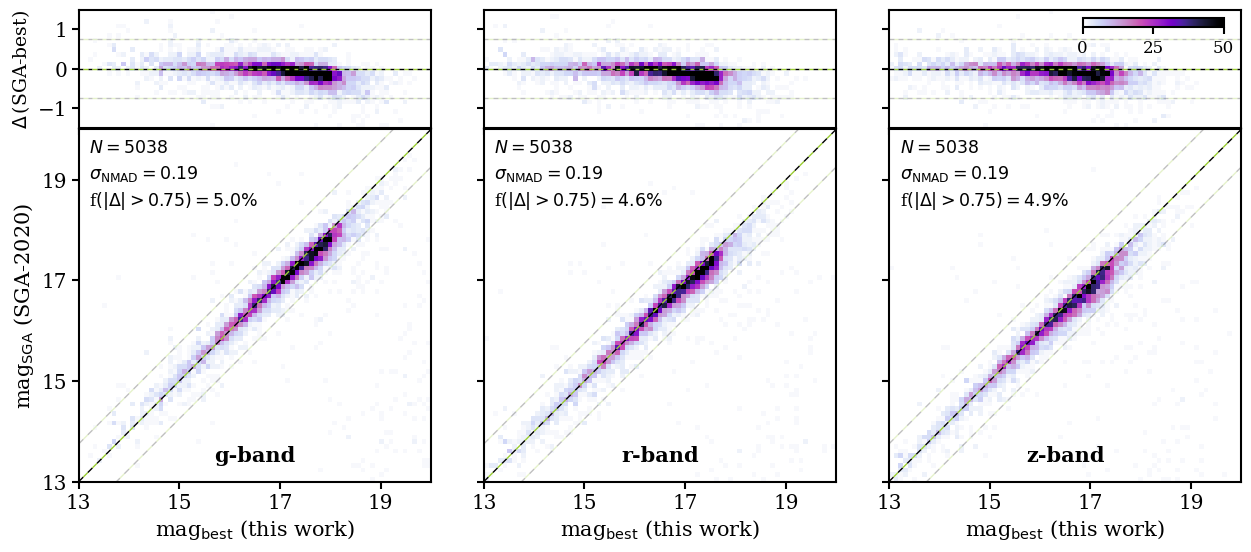

In [209]:
make_compare_plot_3bands(
    ext_mags=sga_mags_all,
    aper_mags=sga_aper_mags_all,
    sga_cat = sga_cat_f,
    band_names=["g", "r", "z"],
    save_path=f"{plot_save_dir}/plots/sga_compare_grz.png",
    show_plot=True,
    ylabel_top = r"$\Delta\,$(SGA-best)", 
    ylabel_bot = r"mag$_{\rm SGA}$ (SGA-2020)", 
    xlabel_bot = r"mag$_{\rm best}$ (this work)",
    mag_min=13, mag_max = 20,
    tickmarks = [13,15,17,19],
    bad_tgids = None
)


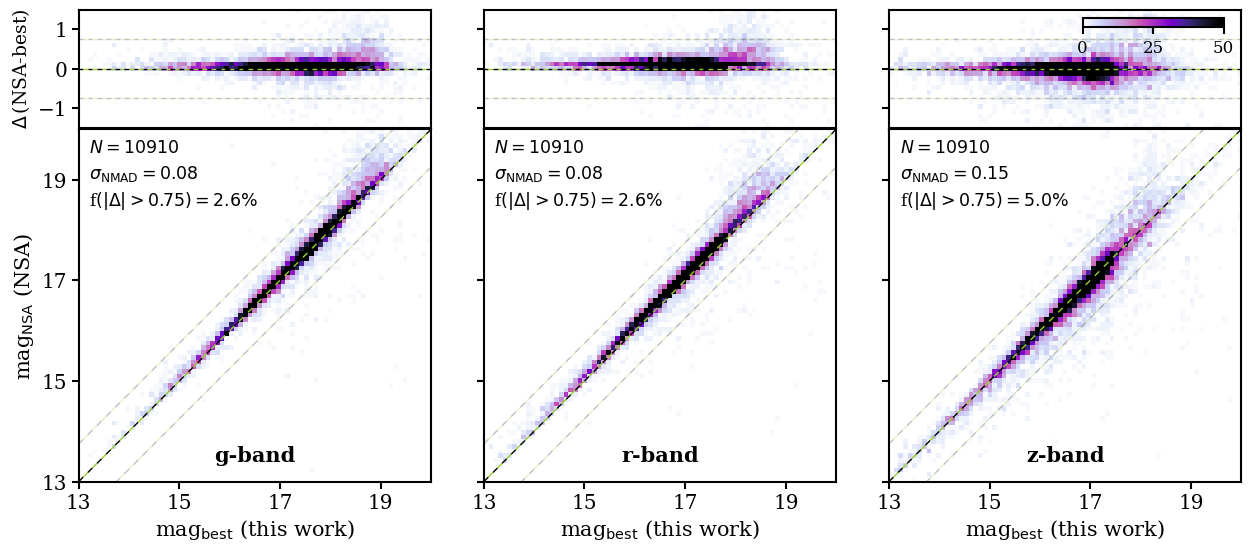

In [213]:
make_compare_plot_3bands(
    ext_mags=nsa_mag_all,
    aper_mags=best_mag_all,
    sga_cat=desi_nsa_match_cat,
    band_names=["g", "r", "z"],
    save_path=f"{plot_save_dir}/plots/nsa_compare_grz.png",
    show_plot=True,
    ylabel_top = r"$\Delta\,$(NSA-best)", 
    ylabel_bot = r"mag$_{\rm NSA}$ (NSA)", 
    xlabel_bot = r"mag$_{\rm best}$ (this work)",
    mag_min=13, mag_max = 20,
    tickmarks = [13,15,17,19]
)

#maybe make a note of NSA < 17.7 outliers


## Compare the sizes in a three panel sequence!! ## comparison between DR9 clean, SGA, and NSA!

In [26]:
##getting the siena catalog subset
siena_cat = Table.read("/global/cfs/cdirs/cosmo/data/sga/2020/SGA-2020.fits")

# Create an index lookup from SGA_ID -> index in siena_cat
id_to_index = {id_: i for i, id_ in enumerate(siena_cat["SGA_ID"])}

# Get matching rows in the same order as sga_cat_f
matching_indices = [id_to_index[id_] for id_ in sga_cat_f["SGA_ID"] if id_ in id_to_index]

siena_cat_sub = siena_cat[matching_indices]

print(np.max(np.abs(siena_cat_sub["SGA_ID"].data - sga_cat_f["SGA_ID"].data)))


0


In [42]:
## get the clean one!

from consolidate_photometry import consolidate_new_photo, consolidate_positions_and_shapes

##load the clean catalog and compare the shape_r and aper_params?

## we need to consolidate the photometry

def get_clean_catalog_stats():
    samps = ["BGS_BRIGHT"] #,"BGS_FAINT"] #,"LOWZ","ELG"]

    all_new_r = []
    all_org_r = []

    all_org_ba = []
    all_new_ba = []
    
    for sampi in samps:
        bgsb_clean_path = f"/pscratch/sd/v/virajvm/catalog_dr1_dwarfs/iron_photometry/iron_{sampi}_clean_catalog_w_aper_mags.fits"
        bgsb_c_cat = Table.read(bgsb_clean_path)
        
        bgsb_c_cat = consolidate_new_photo(bgsb_c_cat,plot=False,sample=sampi, add_pcnn=False)

        print("ADDING SIZE AND SHAPE INFO")
        bgsb_c_cat = consolidate_positions_and_shapes(bgsb_c_cat)
        
        print(len(bgsb_c_cat))
        bgsb_c_cat = bgsb_c_cat[(bgsb_c_cat["PHOTO_MASKBIT"] == 0) & (bgsb_c_cat["MAG_TYPE"] != "TRACTOR_ORIGINAL") ] 

        print(len(bgsb_c_cat))
        
        r_eff_new = bgsb_c_cat["R50_R"].data

        all_new_r.append(bgsb_c_cat["SHAPE_R"].data)
        all_org_r.append(r_eff_new)

        all_org_ba.append( bgsb_c_cat["BA"].data )
        
        all_new_ba.append( bgsb_c_cat["SHAPE_PARAMS"].data[:,0] )
        
        
        
        # data_dict[sampi] = { "SHAPE_R": bgsb_c_cat["SHAPE_R"].data, "R50_R": r_eff_new, "table": bgsb_c_cat  }

    return np.concatenate(all_new_r), np.concatenate(all_org_r), np.concatenate(all_new_ba), np.concatenate(all_org_ba)
        
robust_r_org, robust_r_new, robust_ba_new, robust_ba_org = get_clean_catalog_stats()


Not adding the PCNN values! Adding all 1.
FRACTION REVERT BACK TO TRACTOR: 0.35179735127180994
Need to include the VI column that only does the aperture no subtract photo
Adding the photo maskbits
MASKBIT=2^0, cog nan mask, 0.0001
MASKBIT=2^1, cog not converge, fraction: 0.018394
MASKBIT=2^2, bad resid, fraction : 0.0001
MASKBIT=2^3, cog curve decrease, fraction: 0.0001
MASKBIT=2^4, aperfrac-in image, fraction: 0.000000
MASKBIT=2^5, aperfrac-mask image, fraction: 0.002207
MASKBIT=2^6, image-frac mask, fraction: 0.001051
MASKBIT=2^7, bad colors, fraction: 0.000000
MASKBIT=2^8, source not on segment, fraction: 0.0000
MASKBIT=2^9, within star mask radius and not just a simple blend, fraction: 0.029220
MASKBIT=2^10, aper-cen masked, fraction: 0.000946
MASKBIT=2^11, no seg found, fraction: 0.000000
MASKBIT=2^13, near sga outskirts, fraction: 0.005361
Fraction of sources where org trac is likely good = 0.35179735127180994
Updating the maskbits to reflect some objects reverted to original Tra

100%|██████████| 9514/9514 [00:00<00:00, 193025.79it/s]

Consolidated RA, DEC, and SHAPE_PARAMS columns added. Added PHOTOMETRY_UPDATED column
9514
5980


In [43]:
# different_tgids = [39627839619735986, 39627719486473819	 ]

# sga_larger_tgids = [ 39633497496749329, 39633519558790599  ]

# matching_tgids = [39628453909106683, 39628519977784226 ]

# show_tgids = different_tgids + sga_larger_tgids + matching_tgids

# for i, tgidi in enumerate(show_tgids):
#     index = np.where(sga_cat_f_only_cog["TARGETID"] == tgidi)[0][0]
    
#     ax[0].text(  sga_cat_f_only_cog["R50_R"].data[index], siena_cat_only_cog["R_SMA50"].data[index], 
#            f"{i+1}",fontsize = 12, color = "k",weight="bold")


In [155]:
# ax = make_subplots(ncol=3,nrow=2, col_spacing=0.9,row_spacing = 1)


# ylabel_fs = 13

# ##CLEAN TRACTOR COMPARISON!!
# im = ax[0+3].hist2d(robust_r_new , robust_r_org, 
#              range=((0,20),(0,20)), bins=50,norm=LogNorm(vmin=1, vmax=200), 
#              cmap=cmr.dusk_r,rasterized=True)

# ax[0+3].set_ylabel(r"SHAPE_R [arcsec] (Tractor)",fontsize = ylabel_fs )
# ax[0+3].set_xlabel(r"r-band $R_{50}$ [arcsec] (this work)",fontsize = ylabel_fs )

# ### SGA-COMPARISON!!

# im = ax[1+3].hist2d(sga_cat_f["R50_R"].data, siena_cat_sub["R_SMA50"].data,
#              range=((0,20),(0,20)), bins=50,norm=LogNorm(vmin=1, vmax=200), 
#              cmap=cmr.dusk_r,rasterized=True)
    
# ax[1+3].set_ylabel(r"r-band $R_{50}$ [arcsec] (SGA-2020)",fontsize = ylabel_fs )
# ax[1+3].set_xlabel(r"r-band $R_{50}$ [arcsec] (this work)",fontsize = ylabel_fs )



# ##NSA-COMPARISON!!


# im = ax[2+3].hist2d(desi_nsa_match_cat["R50_R"].data, nsa_match_cat["ELPETRO_TH50_R"].data,
#              range=((0,20),(0,20)), bins=50,norm=LogNorm(vmin=1, vmax=200), 
#              cmap=cmr.dusk_r,rasterized=True)


# ax[2+3].set_ylabel(r"r-band $R_{50}$ [arcsec] (NSA)",fontsize = ylabel_fs )
# ax[2+3].set_xlabel(r"r-band $R_{50}$ [arcsec] (this work)",fontsize = ylabel_fs )

# for i in range(3,6):
#     ax[i].set_ylim([0,20])
#     ax[i].set_xlim([0,20])
#     ax[i].plot([0,50],[0,50],color = "grey",ls="--",lw=0.75)

#     cbar_ax = ax[i].inset_axes([0.07, 0.925, 0.3, 0.02])  # relative to ax_top
#     cbar = plt.colorbar(im[3], cax=cbar_ax, orientation='horizontal')
#     cbar.ax.tick_params(labelsize=12)


# ax[1+3].text(0.75,0.1,"SGA-2020", transform=ax[1+3].transAxes, fontsize = ylabel_fs+1,weight="bold",ha="center" )
# ax[2+3].text(0.75,0.1,"NSA", transform=ax[2+3].transAxes, fontsize = ylabel_fs+1,weight="bold",ha="center" )
# ax[2+3].text(0.65,0.1,"BGS Bright \n(Robust Sources)", transform=ax[0+3].transAxes, fontsize = ylabel_fs+1,weight="bold",ha="center" )


# ################################
# ################################
# ################################
# ################################


# # ylabel_fs = 13

# ##CLEAN TRACTOR COMPARISON!!
# im = ax[0].hist2d(robust_ba_new, robust_ba_org, 
#              range=((0,1),(0,1)), bins=50,norm=LogNorm(vmin=1, vmax=200), 
#              cmap=cmr.dusk_r,rasterized=True)

# ax[0].set_ylabel(r"$b/a$ (Tractor)",fontsize = ylabel_fs )
# ax[0].set_xlabel(r"$b/a$ (this work)",fontsize = ylabel_fs )

# ### SGA-COMPARISON!!

# im = ax[1].hist2d(sga_cat_f["SHAPE_PARAMS"].data[:,0], siena_cat_sub["BA"].data,
#              range=((0,1),(0,1)), bins=50,norm=LogNorm(vmin=1, vmax=200), 
#              cmap=cmr.dusk_r,rasterized=True)
    
# ax[1].set_ylabel(r"$b/a$ (SGA-2020)",fontsize = ylabel_fs )
# ax[1].set_xlabel(r"$b/a$ (this work)",fontsize = ylabel_fs )

# ##NSA-COMPARISON!!


# im = ax[2].hist2d(desi_nsa_match_cat["SHAPE_PARAMS"].data[:,0], nsa_match_cat["ELPETRO_BA"].data,
#              range=((0,1),(0,1)), bins=50,norm=LogNorm(vmin=1, vmax=200), 
#              cmap=cmr.dusk_r,rasterized=True)

# ax[2].set_ylabel(r"$b/a$ (NSA)",fontsize = ylabel_fs )
# ax[2].set_xlabel(r"$b/a$ (this work)",fontsize = ylabel_fs )

# for i in range(3):
#     ax[i].set_ylim([0,1])
#     ax[i].set_xlim([0,1])
#     ax[i].plot([0,1],[0,1],color = "grey",ls="--",lw=0.75)

#     cbar_ax = ax[i].inset_axes([0.07, 0.925, 0.3, 0.02])  # relative to ax_top
#     cbar = plt.colorbar(im[3], cax=cbar_ax, orientation='horizontal')
#     cbar.ax.tick_params(labelsize=12)



# ax[1].text(0.75,0.1,"SGA-2020", transform=ax[1].transAxes, fontsize = ylabel_fs+1,weight="bold",ha="center" )
# ax[2].text(0.75,0.1,"NSA", transform=ax[2].transAxes, fontsize = ylabel_fs+1,weight="bold",ha="center" )
# ax[2].text(0.65,0.1,"BGS Bright \n(Robust Sources)", transform=ax[0].transAxes, fontsize = ylabel_fs+1,weight="bold",ha="center" )


# plt.savefig(f"{plot_save_dir}/plots/different_shape_comps.pdf",bbox_inches="tight")


# ##maybe one

# plt.show()

In [156]:
from desi_lowz_funcs import plot_2d_dist, make_alternating_plot
from catalog_paper_plots import make_cmap


In [118]:
cmr_i = cmr.gothic_r.copy()
cmr_i.set_under(alpha=0.)

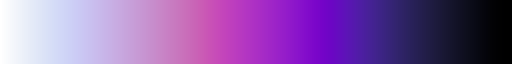

In [119]:
cmr_i

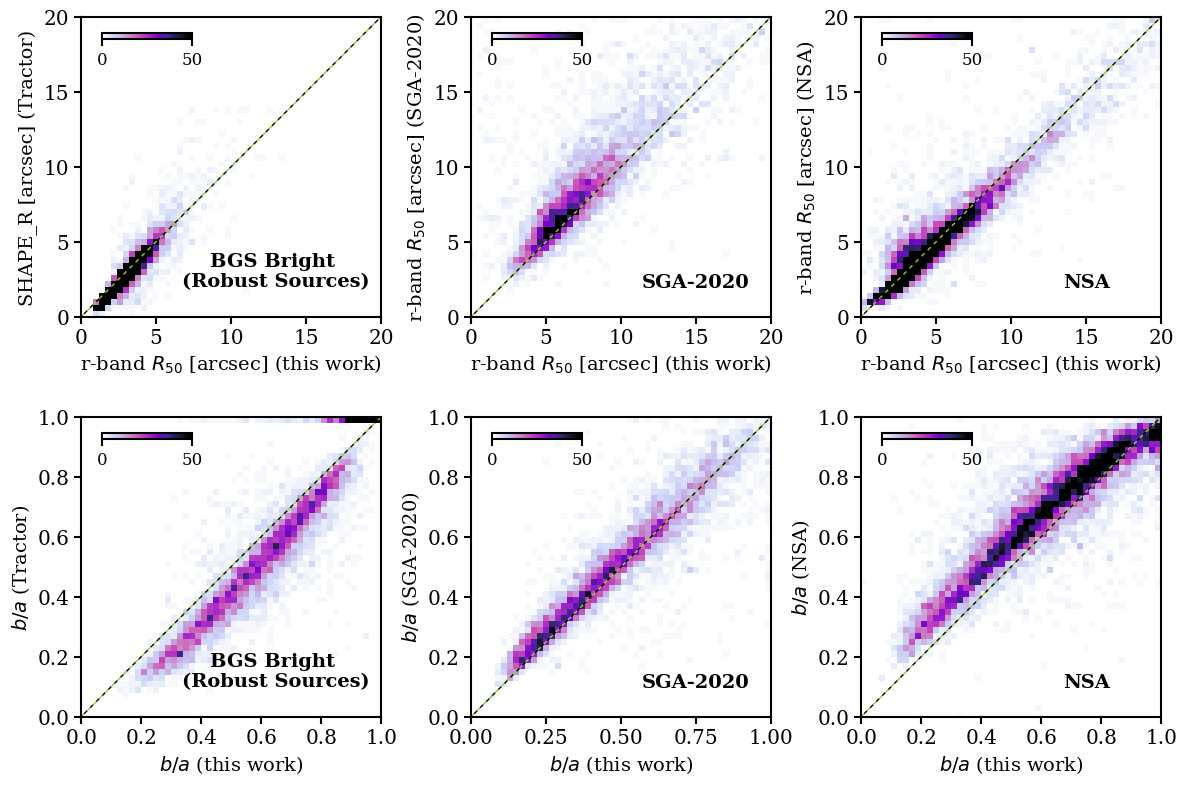

In [154]:
ax = make_subplots(ncol=3,nrow=2, col_spacing=0.9,row_spacing = 1)


ylabel_fs = 14

vmax = 50


##CLEAN TRACTOR COMPARISON!!
im = ax[0+3].hist2d(robust_r_new , robust_r_org, 
             range=((0,20),(0,20)), bins=50,vmin=0,vmax=50, 
             cmap=cmr_i,rasterized=True)

ax[0+3].set_ylabel(r"SHAPE_R [arcsec] (Tractor)",fontsize = ylabel_fs )
ax[0+3].set_xlabel(r"r-band $R_{50}$ [arcsec] (this work)",fontsize = ylabel_fs )

### SGA-COMPARISON!!

im = ax[1+3].hist2d(sga_cat_f["R50_R"].data, siena_cat_sub["R_SMA50"].data,
             range=((0,20),(0,20)), bins=50,vmin=0,vmax=50, 
             cmap=cmr_i,rasterized=True)
    
ax[1+3].set_ylabel(r"r-band $R_{50}$ [arcsec] (SGA-2020)",fontsize = ylabel_fs )
ax[1+3].set_xlabel(r"r-band $R_{50}$ [arcsec] (this work)",fontsize = ylabel_fs )



##NSA-COMPARISON!!


im = ax[2+3].hist2d(desi_nsa_match_cat["R50_R"].data, nsa_match_cat["ELPETRO_TH50_R"].data,
             range=((0,20),(0,20)), bins=50,vmin=0,vmax=50,
             cmap=cmr_i,rasterized=True)


ax[2+3].set_ylabel(r"r-band $R_{50}$ [arcsec] (NSA)",fontsize = ylabel_fs )
ax[2+3].set_xlabel(r"r-band $R_{50}$ [arcsec] (this work)",fontsize = ylabel_fs )

for i in range(3,6):
    ax[i].set_ylim([0,20])
    ax[i].set_xlim([0,20])

    xgrid = np.linspace(0,20,100)
    
    make_alternating_plot(ax[i],xgrid,xgrid,dash_len=1,color_1="yellowgreen",color_2="k",lw=1)

    cbar_ax = ax[i].inset_axes([0.07, 0.925, 0.3, 0.02])  # relative to ax_top
    cbar = plt.colorbar(im[3], cax=cbar_ax, orientation='horizontal')
    cbar.ax.tick_params(labelsize=12)


ax[1+3].text(0.75,0.1,"SGA-2020", transform=ax[1+3].transAxes, fontsize = ylabel_fs,weight="bold",ha="center" )
ax[2+3].text(0.75,0.1,"NSA", transform=ax[2+3].transAxes, fontsize = ylabel_fs,weight="bold",ha="center" )
ax[2+3].text(0.65,0.1,"BGS Bright \n(Robust Sources)", transform=ax[0+3].transAxes, fontsize = ylabel_fs,weight="bold",ha="center" )


################################
################################
################################
################################


# ylabel_fs = 13

vmax = 50
bins=50

##CLEAN TRACTOR COMPARISON!!
im = ax[0].hist2d(robust_ba_new, robust_ba_org, 
             range=((0,1),(0,1)), bins=bins,vmin=0,vmax=vmax, 
             cmap=cmr_i,rasterized=True)

ax[0].set_ylabel(r"$b/a$ (Tractor)",fontsize = ylabel_fs )
ax[0].set_xlabel(r"$b/a$ (this work)",fontsize = ylabel_fs )

### SGA-COMPARISON!!

im = ax[1].hist2d(sga_cat_f["SHAPE_PARAMS"].data[:,0], siena_cat_sub["BA"].data,
             range=((0,1),(0,1)), bins=bins,vmin=0,vmax=vmax,  
             cmap=cmr_i,rasterized=True)
    
ax[1].set_ylabel(r"$b/a$ (SGA-2020)",fontsize = ylabel_fs )
ax[1].set_xlabel(r"$b/a$ (this work)",fontsize = ylabel_fs )

##NSA-COMPARISON!!


im = ax[2].hist2d(desi_nsa_match_cat["SHAPE_PARAMS"].data[:,0], nsa_match_cat["ELPETRO_BA"].data,
             range=((0,1),(0,1)), bins=bins,vmin=0,vmax=vmax, 
             cmap=cmr_i,rasterized=True)

ax[2].set_ylabel(r"$b/a$ (NSA)",fontsize = ylabel_fs )
ax[2].set_xlabel(r"$b/a$ (this work)",fontsize = ylabel_fs )

for i in range(3):
    ax[i].set_ylim([0,1])
    ax[i].set_xlim([0,1])

    xgrid = np.linspace(0,1,100)
    
    make_alternating_plot(ax[i],xgrid,xgrid,dash_len=1,color_1="yellowgreen",color_2="k",lw=1)
    
    cbar_ax = ax[i].inset_axes([0.07, 0.925, 0.3, 0.02])  # relative to ax_top
    cbar = plt.colorbar(im[3], cax=cbar_ax, orientation='horizontal')
    cbar.ax.tick_params(labelsize=12)



ax[1].text(0.75,0.1,"SGA-2020", transform=ax[1].transAxes, fontsize = ylabel_fs,weight="bold",ha="center" )
ax[2].text(0.75,0.1,"NSA", transform=ax[2].transAxes, fontsize = ylabel_fs,weight="bold",ha="center" )
ax[2].text(0.65,0.1,"BGS Bright \n(Robust Sources)", transform=ax[0].transAxes, fontsize = ylabel_fs,weight="bold",ha="center" )


plt.savefig(f"{plot_save_dir}/plots/different_shape_comps.pdf",bbox_inches="tight")

##maybe one

plt.show()

# Make a plot of FRACFLUX vs. delta mag!!

In [300]:
def make_fracflux_compare_plot(axs, all_fracs, new_mags, tractor_mags, ext_mags, title = None):
    

    if title is not None:
        axs[1].set_title(title,fontsize = 15)
    
    bins = 50

    all_dms_org = new_mags - tractor_mags
    
    all_dms_new = new_mags - ext_mags
    
    im = axs[1].hist2d( all_fracs, all_dms_new,
                 range=( (1e-2,5), (-5,0.5) ), bins = [ np.logspace(-2, np.log10(5), bins), np.linspace(-5,2,bins) ],
                 norm=LogNorm(vmin=1,vmax=200),cmap = cmr.dusk_r, rasterized=True)
    
    im = axs[0].hist2d( all_fracs, all_dms_org,
                 range=( (1e-2,5), (-5,0.5) ), bins = [ np.logspace(-2, np.log10(5), bins), np.linspace(-5,2,bins) ],
                 norm=LogNorm(vmin=1,vmax=200),cmap = cmr.dusk_r,rasterized=True)


    for i in range(2):
        axs[i].set_xlim([1e-2,5])
        axs[i].set_ylim([-5,2])
        axs[i].set_xscale("log")
        axs[i].hlines(y = 0,xmin=1e-2, xmax = 5,ls = "--",color = "grey",lw =1 )
        axs[i].vlines(x = 0.2, ymin = -5, ymax = 2, color= "grey", ls = "--",lw = 1)
        axs[i].set_xlabel(r"FRACFLUX",fontsize = 15)

    #insert a colorbar
    # colbar_x, colbar_y = 0.0775, 0.08
    
    # cbar = plt.colorbar(im[3], ax=ax[1], orientation='horizontal', pad=0.05)
    # cbar.ax.set_position([
    # colbar_x,   # Left position
    # colbar_y,  # Top position
    # ax[1].get_position().width * 0.065,  # Width (40% of plot width)
    # 0.015  # Height (thin bar)
    # ])

    # ax[1].set_xticklabels([])
    
    return


In [265]:
from sga_nsa_comp_funcs import get_fracflux_change_curve, get_all_ff_deltas

In [267]:
ff_bgsb, mag_new_bgsb, mag_trac_bgsb = get_all_ff_deltas("BGS_BRIGHT")
ff_bgsf, mag_new_bgsf, mag_trac_bgsf = get_all_ff_deltas("BGS_FAINT")
ff_lowz, mag_new_lowz, mag_trac_lowz = get_all_ff_deltas("LOWZ")
ff_elg, mag_new_elg, mag_trac_elg = get_all_ff_deltas("ELG")


samp_ff = np.concatenate([ff_bgsb, ff_bgsf, ff_lowz, ff_elg])
samp_mag_new = np.concatenate([mag_new_bgsb, mag_new_bgsf, mag_new_lowz, mag_new_elg])
samp_mag_trac = np.concatenate([mag_trac_bgsb, mag_trac_bgsf, mag_trac_lowz, mag_trac_elg])



Not adding the PCNN values! Adding all 1.
FRACTION REVERT BACK TO TRACTOR: 0.23503663526501095
Need to include the VI column that only does the aperture no subtract photo
Adding the photo maskbits
MASKBIT=2^0, cog nan mask, 0.0031
MASKBIT=2^1, cog not converge, fraction: 0.058949
MASKBIT=2^2, bad resid, fraction : 0.0056
MASKBIT=2^3, cog curve decrease, fraction: 0.0096
MASKBIT=2^4, aperfrac-in image, fraction: 0.001047
MASKBIT=2^5, aperfrac-mask image, fraction: 0.047007
MASKBIT=2^6, image-frac mask, fraction: 0.000809
MASKBIT=2^7, bad colors, fraction: 0.000333
MASKBIT=2^8, source not on segment, fraction: 0.0000
MASKBIT=2^9, within star mask radius and not just a simple blend, fraction: 0.102151
MASKBIT=2^10, aper-cen masked, fraction: 0.048958
MASKBIT=2^11, no seg found, fraction: 0.000048
MASKBIT=2^13, near sga outskirts, fraction: 0.013798
Fraction of sources where org trac is likely good = 0.23503663526501095
Updating the maskbits to reflect some objects reverted to original Tra

In [317]:
bin_samp_cumu, frac_samp_cumu = get_fracflux_change_curve(samp_ff, samp_mag_new, samp_mag_trac,mag_cut = 0.75)
bin_samp, frac_samp = get_fracflux_change_curve(samp_ff, samp_mag_new, samp_mag_trac,mag_cut = 0.75,cumulative=False)



NameError: name 'nsa_ff_all' is not defined

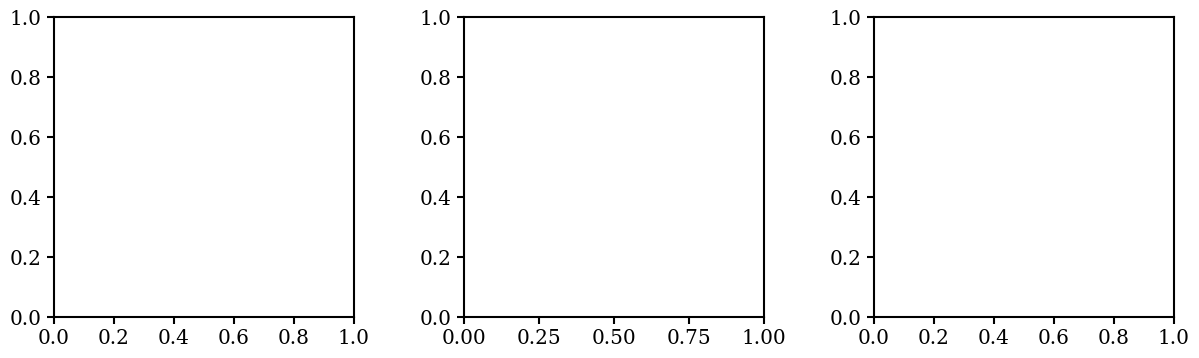

In [20]:
ax = make_subplots(ncol = 3, nrow = 1, col_spacing = 1.1)

all_fracs_sga = ff_all
all_trac_mags_sga = np.concatenate(sga_trac_mags_all)
all_new_mags_sga =  np.concatenate(sga_aper_mags_all)
all_ext_mags_sga = np.concatenate(sga_mags_all)


all_fracs_nsa = nsa_ff_all
all_trac_mags_nsa = np.concatenate(nsa_trac_mag)
all_new_mags_nsa =  np.concatenate(best_mag_all)
all_ext_mags_nsa = np.concatenate(nsa_mag_all)

#then combine acrosss the two external catalogs

all_fracs = np.concatenate([all_fracs_sga, all_fracs_nsa])
all_trac_mags = np.concatenate([all_trac_mags_sga, all_trac_mags_nsa])
all_new_mags = np.concatenate([all_new_mags_sga, all_new_mags_nsa])
all_ext_mags = np.concatenate([all_ext_mags_sga, all_ext_mags_nsa])


make_fracflux_compare_plot([ ax[0], ax[1] ], all_fracs, all_new_mags, all_trac_mags, all_ext_mags, title = None)

ax[0].set_ylabel(r"$\Delta$ = mag$_{\rm best}$ - mag$_{\rm DR9}$",fontsize = 15)
ax[1].set_ylabel(r"mag$_{\rm best}$ - mag$_{\rm SGA\,/\,NSA}$",fontsize = 15)


###
ax[2].plot(bin_samp_cumu, 1-np.array(frac_samp_cumu), color = "k",lw=2)

ax[2].set_xlim([1e-2,5])
ax[2].set_ylim([0.90,1])
ax[2].set_xscale("log")
ax[2].vlines(x = 0.2, ymin = -5, ymax = 2, color= "grey", ls = "--",lw = 1)
ax[2].set_xlabel(r"FRACFLUX",fontsize = 15)

ax[2].set_ylabel(r"$f_{|\Delta| < 0.75}$($\leq$FRACFLUX)", fontsize=15)



plt.show()

What is that cloud of points in the SGA objects?

Some are bright HII regions in the outskirts of massive galaxies!!

In [149]:
# sga_cat_f[ (sga_cat_f["FRACFLUX_R"] < 0.1) & (sga_cat_f["MAG_R_BEST"] - sga_cat_f["MAG_R"] < -4) ]["FILE_PATH"]

Below we VI the outlier examples to see where we are correct etc. so we can mark those

In [13]:
# r_outlier_mask = (np.abs(sga_mags_all[1] - sga_aper_mags_all[1]) > 0.75)

# print(np.sum(r_outlier_mask)/len(r_outlier_mask))

0.04313319530710835


## Make SGA vs. our reconstruction comparison panels!!

Each galaxy will just be a single panel with RGB image and the half light radius shown ... 

In [9]:
##getting the siena catalog subset

siena_cat = Table.read("/global/cfs/cdirs/cosmo/data/sga/2020/SGA-2020.fits")

# Create an index lookup from SGA_ID -> index in siena_cat
id_to_index = {id_: i for i, id_ in enumerate(siena_cat["SGA_ID"])}

# Get matching rows in the same order as sga_cat_f
matching_indices = [id_to_index[id_] for id_ in sga_cat_f["SGA_ID"] if id_ in id_to_index]

siena_cat_sub = siena_cat[matching_indices]

print(np.max(np.abs(siena_cat_sub["SGA_ID"].data - sga_cat_f["SGA_ID"].data)))

0


In [10]:
from sga_nsa_comp_funcs import plot_one_panel_model_comp

In [11]:
len(sga_cat_f)

5796

In [12]:
## these were the targetids we ended up using 

match_tgids = [39628453909106683, 39628519977784226, 39628242226776575, 39627833768675783, 39628343561161817 ]
match_cutouts = [180,130, 90, 120, 75 ]


# 39627839619735986, 39627719486473819
# 39633005911739676,120
better_tgids =  [39627839619735986,  39628521420621906,39627761270130297, 39627790617677285, 39628514688765577,  39627873182548501, 39628155731837269,  ]
better_cutouts = [120, 120,75,140, 90, 75,75, 120]

worse_tgids = [39628510922280854, 39627999334629687, 39633195234232369, 39627764218725430, 39633319020726783,  39628492018548927 ]
worse_cutouts = [120, 60, 60, 60,120, 120   ]


ambi_tgids = [39633458183540035, 39628285465856538, 39627812646160269, 39627860951960648,39633271088218330,  39633204214236654, 39628164820898156]
ambi_cutouts = [90, 90, 120, 75,75, 90, 90]

#combine this all in a dict
all_tgids = match_tgids + better_tgids + worse_tgids + ambi_tgids
all_cutouts = match_cutouts + better_cutouts + worse_cutouts + ambi_cutouts

cutout_size_dict = {}
for i,tgidi in enumerate(all_tgids):
    cutout_size_dict[tgidi] = all_cutouts[i]


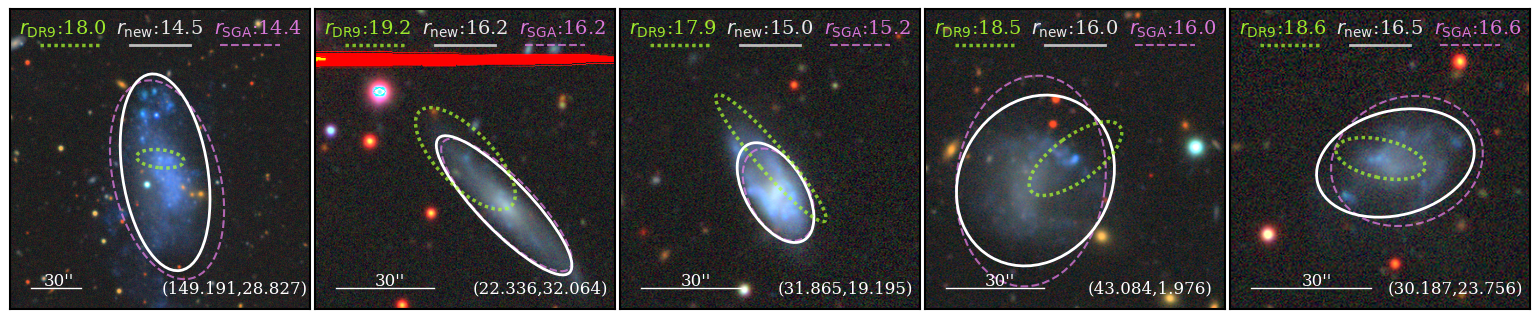

In [15]:
ax = make_subplots(ncol=5,nrow=1,col_spacing=0.05,plot_size=3)

for i in range(5):

    plot_one_panel_model_comp([ax[i]],match_tgids[i], sga_cat_f, siena_cat_sub,
                                 alpha=0.7,linewidth=2,
                                 sga_ls = "--",sga_color = "violet",
                                 new_ls = "-", new_color = "white",
                                  trac_ls  = (0,(1,1)), trac_color="greenyellow",
                                 scale_f = 2, cutout_size_arcsec = cutout_size_dict[match_tgids[i]],
                                verbose=False,use_sga_r50=True,
                                 bar_size_arc=30,bar_size_str="30''")
    
plt.savefig(f"{plot_save_dir}/plots/sga_match_comparison.png",bbox_inches="tight")

plt.show()

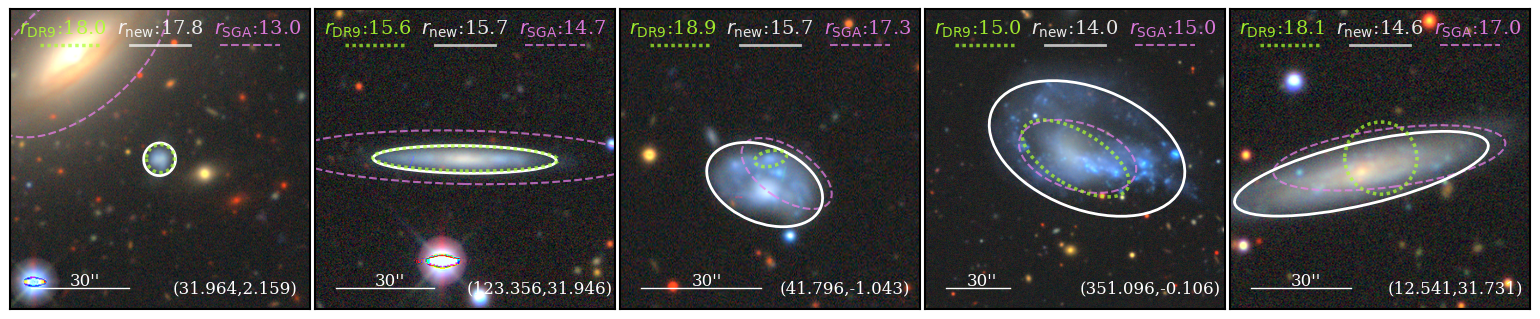

In [17]:
ax = make_subplots(ncol=5,nrow=1,col_spacing=0.05,plot_size=3)

for i in range(5):

    plot_one_panel_model_comp([ax[i]],better_tgids[i], sga_cat_f, siena_cat_sub,
                                 alpha=0.7,linewidth=2,
                                 sga_ls = "--",sga_color = "violet",
                                 new_ls = "-", new_color = "white",
                                  trac_ls  = (0,(1,1)), trac_color="greenyellow",
                                 scale_f = 2, cutout_size_arcsec = cutout_size_dict[better_tgids[i]],
                                verbose=False,use_sga_r50=True,
                                 bar_size_arc=30,bar_size_str="30''")
    
plt.savefig(f"{plot_save_dir}/plots/sga_better_comparison.png",bbox_inches="tight")

plt.show()

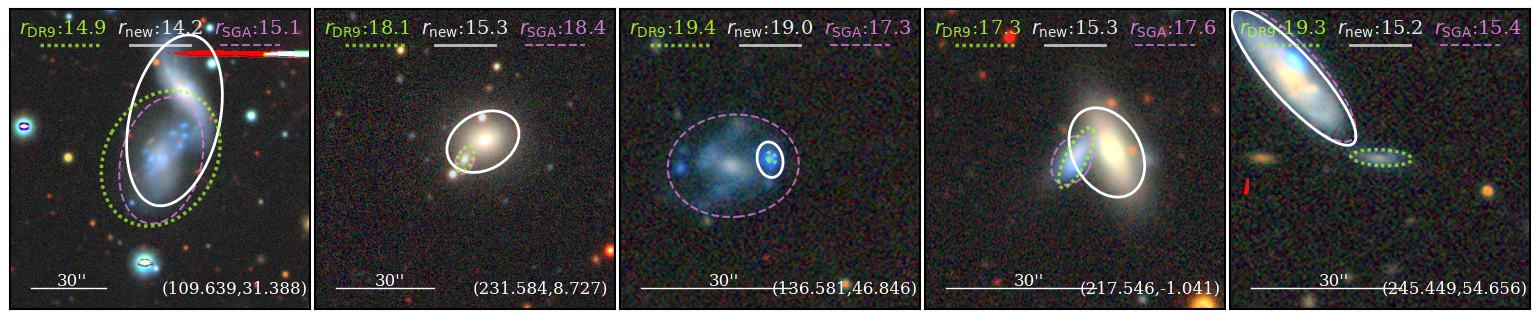

In [18]:
ax = make_subplots(ncol=5,nrow=1,col_spacing=0.05,plot_size=3)

for i in range(5):

    plot_one_panel_model_comp([ax[i]],worse_tgids[i], sga_cat_f, siena_cat_sub,
                                 alpha=0.7,linewidth=2,
                                 sga_ls = "--",sga_color = "violet",
                                 new_ls = "-", new_color = "white",
                                  trac_ls  = (0,(1,1)), trac_color="greenyellow",
                                 scale_f = 2, cutout_size_arcsec = cutout_size_dict[worse_tgids[i]],
                                verbose=False,use_sga_r50=True,
                                 bar_size_arc=30,bar_size_str="30''")
    

plt.savefig(f"{plot_save_dir}/plots/sga_worse_comparison.png",bbox_inches="tight")

plt.show()

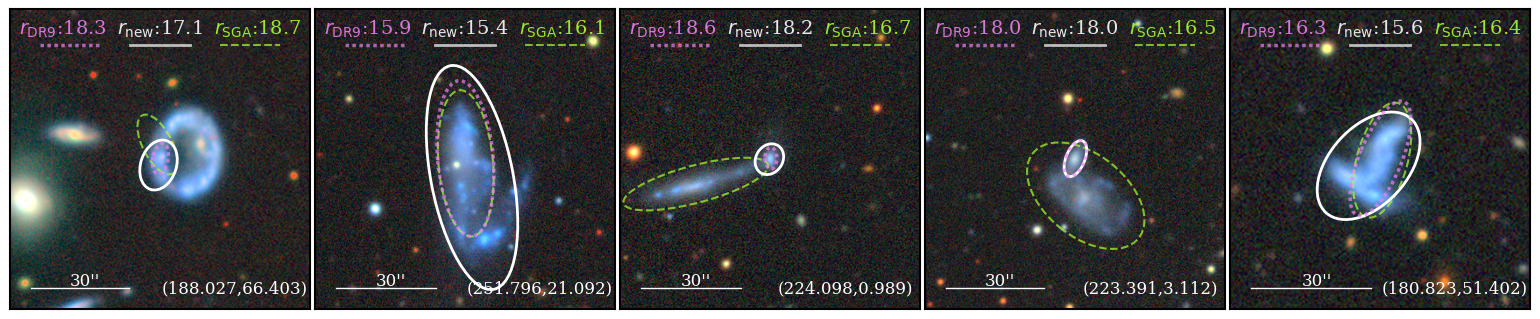

In [19]:
ax = make_subplots(ncol=5,nrow=1,col_spacing=0.05,plot_size=3)

for i in range(5):

    plot_one_panel_model_comp([ax[i]],ambi_tgids[i], sga_cat_f, siena_cat_sub,
                                 alpha=0.7,linewidth=2,
                                 sga_ls = "--",sga_color = "greenyellow",
                                 new_ls = "-", new_color = "white",
                                  trac_ls  = (0,(1,1)), trac_color="violet",
                                 scale_f = 2, cutout_size_arcsec = cutout_size_dict[ambi_tgids[i]],
                                verbose=False,use_sga_r50=True,
                                 bar_size_arc=30,bar_size_str="30''")
    

plt.savefig(f"{plot_save_dir}/plots/sga_ambi_comparison.png",bbox_inches="tight")


plt.show()

## What is happening in SGA at the faint end?

In [63]:
from consolidate_photometry import consolidate_cog_photo
from shred_photometry_maskbits import create_shred_maskbits_from_dict

def sga_consolidate_cog(cat,sample):
    '''
    Here we consolidate the photo

    if only_cog=True, we only consolidate the cog photometries and do not bother with the tractor based ones.
    if false, then we find consolidate over all those different photometries
    '''

    ##do not do any consolidation, we will be using the COG mag here, but just need to identify when it is best!!

    cat = consolidate_cog_photo(cat,sample=sample, add_pcnn=True)

    cat["MAG_G_BEST"] = cat["COG_MAG_G_FINAL"].data.copy()
    cat["MAG_R_BEST"] = cat["COG_MAG_R_FINAL"].data.copy()
    cat["MAG_Z_BEST"] = cat["COG_MAG_Z_FINAL"].data.copy()
    #and for this case the COG_MAG_X_FINAL is the best one so we will copy it to this to avoid any bugs in the popeline

    #we want to only select the objects where COG is preffered?
    
    #add maskbits to find when cog is reliable!
    bitmasks_list = [0,1,2,3,4,5,6,7,8,9,10]

    print("Adding the COG photo maskbits")
    photo_maskbits =  create_shred_maskbits_from_dict(cat, bitmasks_to_apply = bitmasks_list, verbose=True)
    cat["PHOTO_MASKBIT"] = photo_maskbits

    #identifying the robust ones!
    cat = cat[cat["PHOTO_MASKBIT"] == 0]

    return cat


sga_cat = Table.read("/pscratch/sd/v/virajvm/catalog_dr1_dwarfs/iron_photometry/iron_SGA_sga_catalog_w_aper_mags.fits")

sga_cat_only_cog = sga_consolidate_cog(sga_cat,"SGA")


Added PCNN values!
Adding the COG photo maskbits
MASKBIT=2^0, cog nan mask, 0.0011
MASKBIT=2^1, cog not converge, fraction: 0.028612
MASKBIT=2^2, bad resid, fraction : 0.0019
MASKBIT=2^3, cog curve decrease, fraction: 0.0036
MASKBIT=2^4, aperfrac-in image, fraction: 0.005659
MASKBIT=2^5, aperfrac-mask image, fraction: 0.001886
MASKBIT=2^6, image-frac mask, fraction: 0.000314
MASKBIT=2^7, bad colors, fraction: 0.002201
MASKBIT=2^8, source not on segment, fraction: 0.0000
MASKBIT=2^9, within star mask radius and not just a simple blend, fraction: 0.022324
MASKBIT=2^10, aper-cen masked, fraction: 0.005188


In [158]:
ff_lim = 0.1

sga_faint = sga_cat_only_cog[(sga_cat_only_cog["MAG_R"] > 14) & (sga_cat_only_cog["FRACFLUX_G"] < ff_lim)  & (sga_cat_only_cog["FRACFLUX_R"] < ff_lim)  & (sga_cat_only_cog["FRACFLUX_Z"] < ff_lim)   ]


In [159]:
len(sga_faint)

4137

In [166]:
from desi_lowz_funcs import get_contours

cont_my = get_contours(sga_faint["MAG_R"].data, sga_faint["MAG_R_BEST"].data - sga_faint["MAG_R"].data , bins = np.arange(14,18.5,0.25),sigs=True)
cont_sga = get_contours(sga_faint["MAG_R"].data,sga_faint["SGA_R_COG_MAG"].data - sga_faint["MAG_R"].data, bins = np.arange(14,18.5,0.25),sigs=True)


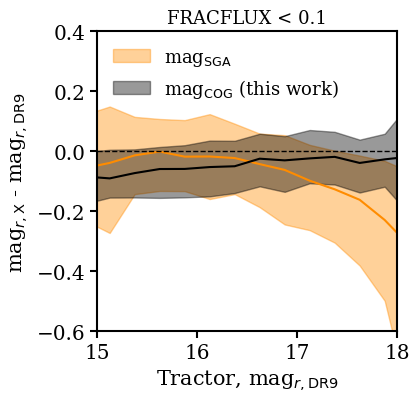

In [165]:
fig,ax = make_subplots(ncol=1,nrow=1,return_fig=True)

ax[0].set_title(r"FRACFLUX < 0.1",fontsize = 13)
ax[0].plot(cont_sga["bin_cents"],cont_sga["median"],color = "darkorange")
ax[0].fill_between(x = cont_sga["bin_cents"],y1=cont_sga["sig1_low"], y2=cont_sga["sig1_high"],color = "darkorange",alpha=0.4,label =  r"mag$_{\rm SGA}$")
# ax[0].fill_between(x = cont_sga["bin_cents"],y1=cont_sga["sig2_low"], y2=cont_sga["sig2_high"],color = "darkorange",alpha=0.2)


ax[0].plot(cont_my["bin_cents"],cont_my["median"],color = "k")
ax[0].fill_between(x = cont_my["bin_cents"],y1=cont_my["sig1_low"], y2=cont_my["sig1_high"],color = "k",alpha=0.4,label = r"mag$_{\rm COG}$ (this work)")
# ax[0].fill_between(x = cont_my["bin_cents"],y1=cont_my["sig2_low"], y2=cont_my["sig2_high"],color = "mediumblue",alpha=0.2)

ax[0].set_ylim([-0.6,0.4])

ax[0].axhline(y = 0, color = "k",lw = 1,ls = "--")

ax[0].set_xlim([15,18])

ax[0].legend(frameon=False,fontsize = 13,loc = "upper left")

ax[0].set_xlabel(r"Tractor, mag$_{r,\rm DR9}$",fontsize = 15)
ax[0].set_ylabel(r"mag$_{r,\rm X}$ - mag$_{r,\rm DR9}$",fontsize = 15)

plt.savefig("plots/sga_vs_my_method_clean_comp.pdf",bbox_inches="tight")

plt.show()



(-1.0, 1.0)

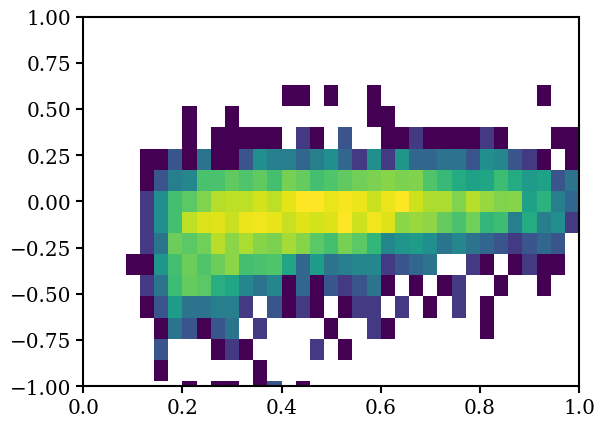

In [340]:
plt.hist2d(sga_faint["SGA_BA"].data, sga_faint["SGA_R_COG_MAG"].data - sga_faint["MAG_R"].data,
           range= ((0,1),(-2,2) ),
          bins=35, norm=LogNorm() )
plt.ylim([-1,1])